# Electricity Consumption Prediction

---

![](https://images.unsplash.com/photo-1521618755572-156ae0cdd74d?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1656&q=80)
Photo by [Zbynek Burival](https://unsplash.com/photos/V4ZYJZJ3W4M)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#I.-Key-concepts-in-time-series" data-toc-modified-id="I.-Key-concepts-in-time-series-1">I. Key concepts in time series</a></span></li><li><span><a href="#III.-Decomposition-and-forecasting" data-toc-modified-id="III.-Decomposition-and-forecasting-2">III. Decomposition and forecasting</a></span><ul class="toc-item"><li><span><a href="#1.-Trends" data-toc-modified-id="1.-Trends-2.1">1. Trends</a></span></li><li><span><a href="#2.-Seasonality" data-toc-modified-id="2.-Seasonality-2.2">2. Seasonality</a></span></li><li><span><a href="#3.-Automatic-Decomposition" data-toc-modified-id="3.-Automatic-Decomposition-2.3">3. Automatic Decomposition</a></span></li><li><span><a href="#4.-Model-the-stationary-series" data-toc-modified-id="4.-Model-the-stationary-series-2.4">4. Model the stationary series</a></span><ul class="toc-item"><li><span><a href="#Moving-Average-(MA)-processes" data-toc-modified-id="Moving-Average-(MA)-processes-2.4.1">Moving Average (MA) processes</a></span></li><li><span><a href="#Auto-Regressive-(AR)-processes" data-toc-modified-id="Auto-Regressive-(AR)-processes-2.4.2">Auto Regressive (AR) processes</a></span></li><li><span><a href="#Auto-Regressive-Moving-Average-(ARMA)-processes" data-toc-modified-id="Auto-Regressive-Moving-Average-(ARMA)-processes-2.4.3">Auto Regressive Moving Average (ARMA) processes</a></span></li><li><span><a href="#Auto-Regressive-Integrated-Moving-Average-(ARIMA)-processes" data-toc-modified-id="Auto-Regressive-Integrated-Moving-Average-(ARIMA)-processes-2.4.4">Auto Regressive Integrated Moving Average (ARIMA) processes</a></span></li><li><span><a href="#Seasonal-Autoregressive-Integrated-Moving-Average-(SARIMA)-process" data-toc-modified-id="Seasonal-Autoregressive-Integrated-Moving-Average-(SARIMA)-process-2.4.5">Seasonal Autoregressive Integrated Moving-Average (SARIMA) process</a></span></li><li><span><a href="#Time-series-recomposition" data-toc-modified-id="Time-series-recomposition-2.4.6">Time series recomposition</a></span></li></ul></li><li><span><a href="#5.-Using-Prophet" data-toc-modified-id="5.-Using-Prophet-2.5">5. Using Prophet</a></span></li></ul></li></ul></div>

In this notebook, we will be working with time series of Open Power System Data ([OPSD](https://open-power-system-data.org/)) for Germany. 

The data set includes daily electricity consumption, wind power production, and solar power production between 2006 and 2017. 
```
- Date — The date (yyyy-mm-dd format)
- Consumption — Electricity consumption in GWh
- Wind — Wind power production in GWh
- Solar — Solar power production in GWh
- Wind+Solar — Sum of wind and solar power production in GWh
```

In [95]:
# Imports
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime as d

import statsmodels.api as sm

import matplotlib.pyplot as plt

import seaborn as sns

import plotly.express as px

In [2]:
# Load file
df = pd.read_csv('opsd_germany_daily.csv')

# Data exploration

In [3]:
# Description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4383 non-null   object 
 1   Consumption  4383 non-null   float64
 2   Wind         2920 non-null   float64
 3   Solar        2188 non-null   float64
 4   Wind+Solar   2187 non-null   float64
dtypes: float64(4), object(1)
memory usage: 171.3+ KB


In [4]:
df.describe()

Consumption         Wind        Solar   Wind+Solar
count  4383.000000  2920.000000  2188.000000  2187.000000
mean   1338.675836   164.814173    89.258695   272.663481
std     165.775710   143.692732    58.550099   146.319884
min     842.395000     5.757000     1.968000    21.478000
25%    1217.859000    62.353250    35.179250   172.185500
50%    1367.123000   119.098000    86.407000   240.991000
75%    1457.761000   217.900250   135.071500   338.988000
max    1709.568000   826.278000   241.580000   851.556000

In [5]:
# Transform the dates into datetime format
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.set_index('Date', drop=True, inplace=True)

In [6]:
df

Consumption     Wind   Solar  Wind+Solar
Date                                                
2006-01-01   1069.18400      NaN     NaN         NaN
2006-01-02   1380.52100      NaN     NaN         NaN
2006-01-03   1442.53300      NaN     NaN         NaN
2006-01-04   1457.21700      NaN     NaN         NaN
2006-01-05   1477.13100      NaN     NaN         NaN
...                 ...      ...     ...         ...
2017-12-27   1263.94091  394.507  16.530     411.037
2017-12-28   1299.86398  506.424  14.162     520.586
2017-12-29   1295.08753  584.277  29.854     614.131
2017-12-30   1215.44897  721.247   7.467     728.714
2017-12-31   1107.11488  721.176  19.980     741.156

[4383 rows x 4 columns]

### 1. Plotting and understanding a time series

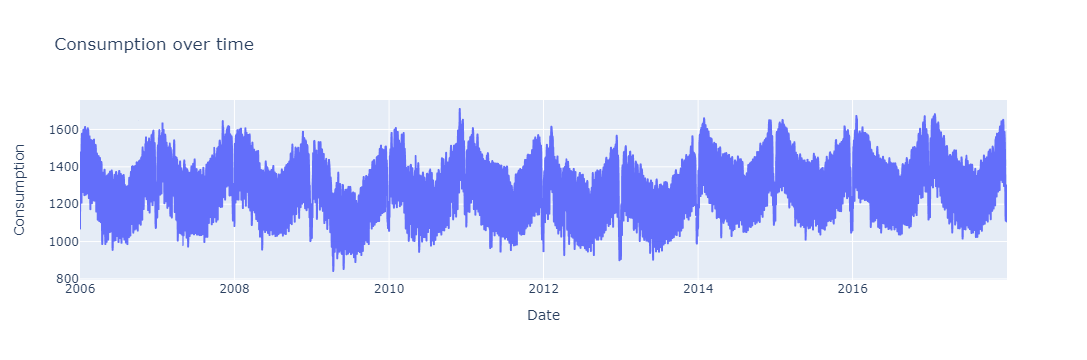

In [7]:
px.line(data_frame=df,x=df.index, y='Consumption', title="Consumption over time")

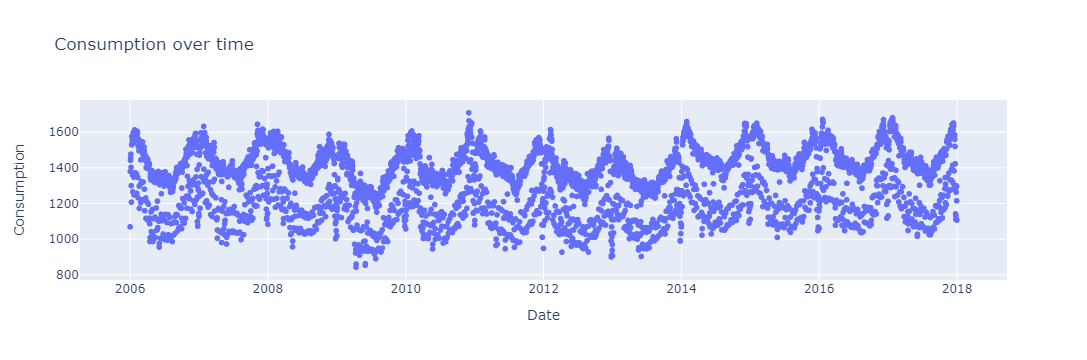

In [8]:
px.scatter(data_frame=df,x=df.index, y='Consumption', title="Consumption over time")

We notice (when zooming on the scatter plot) that consumption is lower during weekends. This cannot be seen using the line plot.

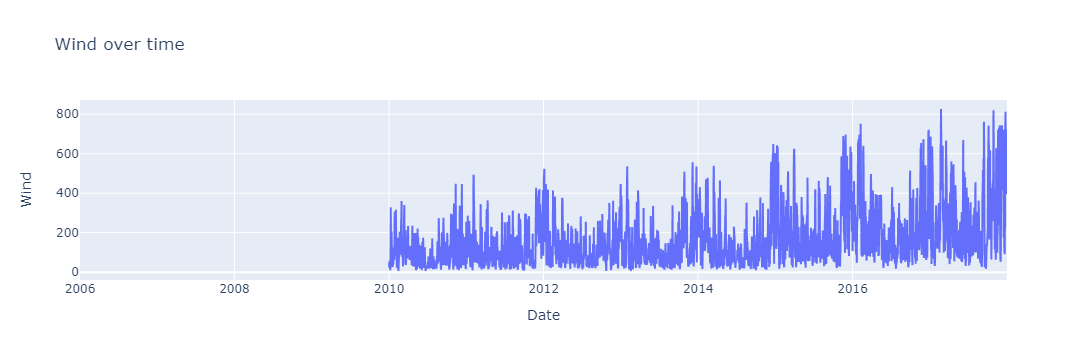

In [9]:
px.line(data_frame=df,x=df.index, y='Wind', title="Wind over time")

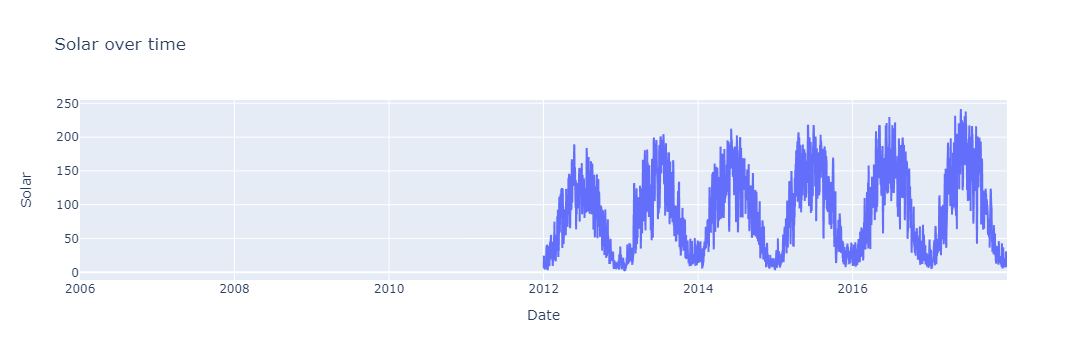

In [10]:
px.line(data_frame=df,x=df.index, y='Solar', title="Solar over time")

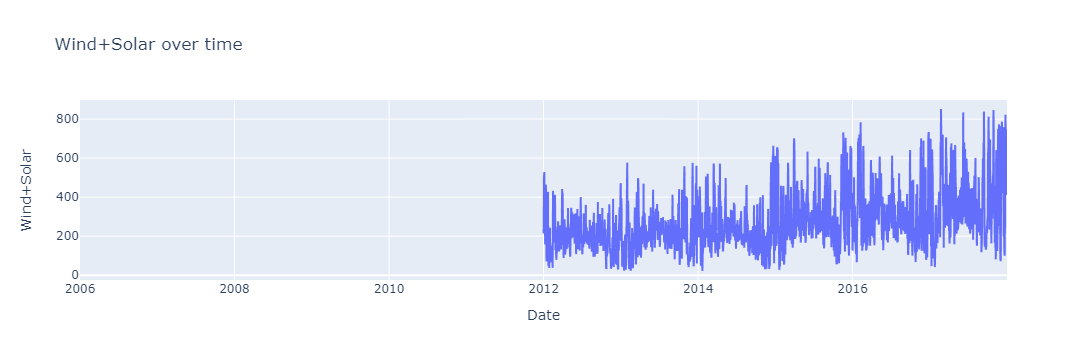

In [11]:
px.line(data_frame=df,x=df.index, y='Wind+Solar', title="Wind+Solar over time")

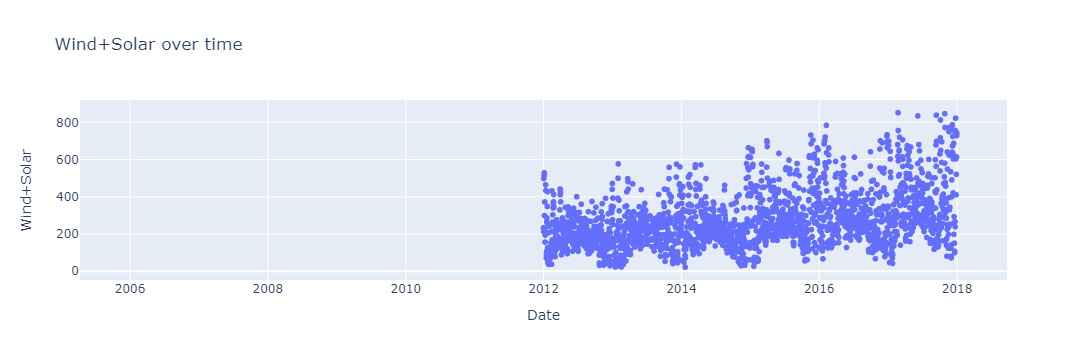

In [12]:
px.scatter(data_frame=df,x=df.index, y='Wind+Solar', title="Wind+Solar over time")

We see on this curve that the solar power seasonality is reflected on the global production curve, so the production is a bit seasonal (more solar power during summers, more wind power during winters).

In [13]:
df['Prod-Cons'] = df['Wind+Solar']-df['Consumption']

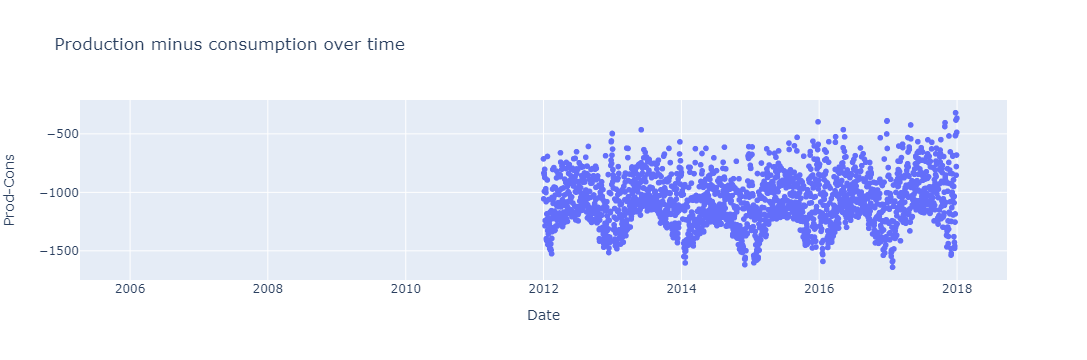

In [14]:
px.scatter(data_frame=df,x=df.index, y='Prod-Cons', title="Production minus consumption over time")

We can see that production is not sufficient compared to the consumption. Moreover, production particularly lacking during winters where consumption is higher (needs for heating) but the lack of solar power is not compensated by the increase of wind.

### 2. Change the scale

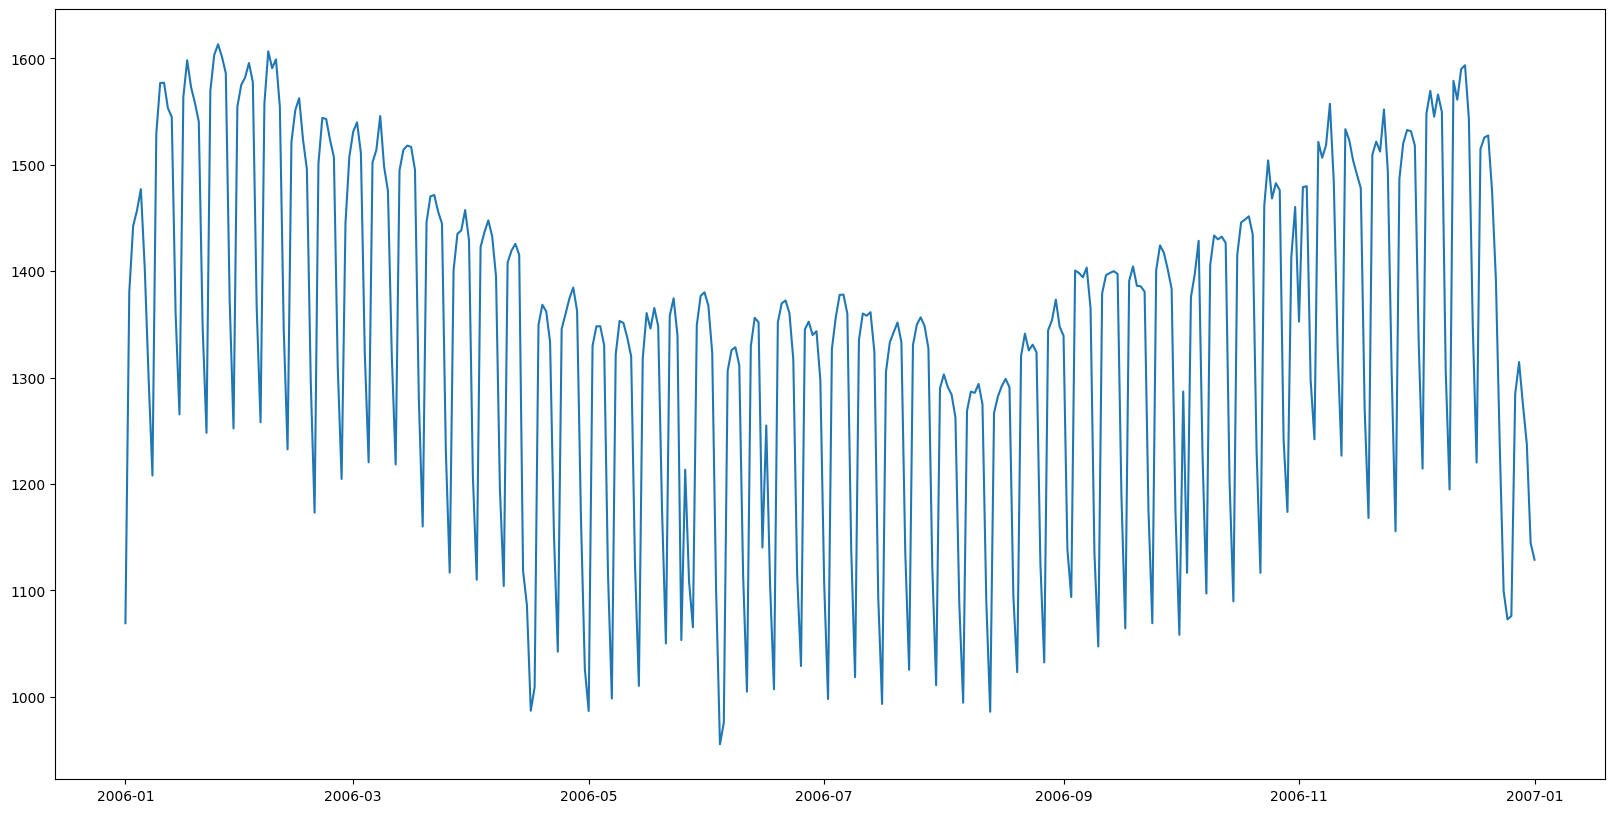

In [15]:
# Plot over the year
plt.figure(figsize=(20,10))
plt.plot(df['Consumption'][:366])
plt.show()

It confirms the trend : more consumption in winter time, and less in summer. We can then zoom on a given month :

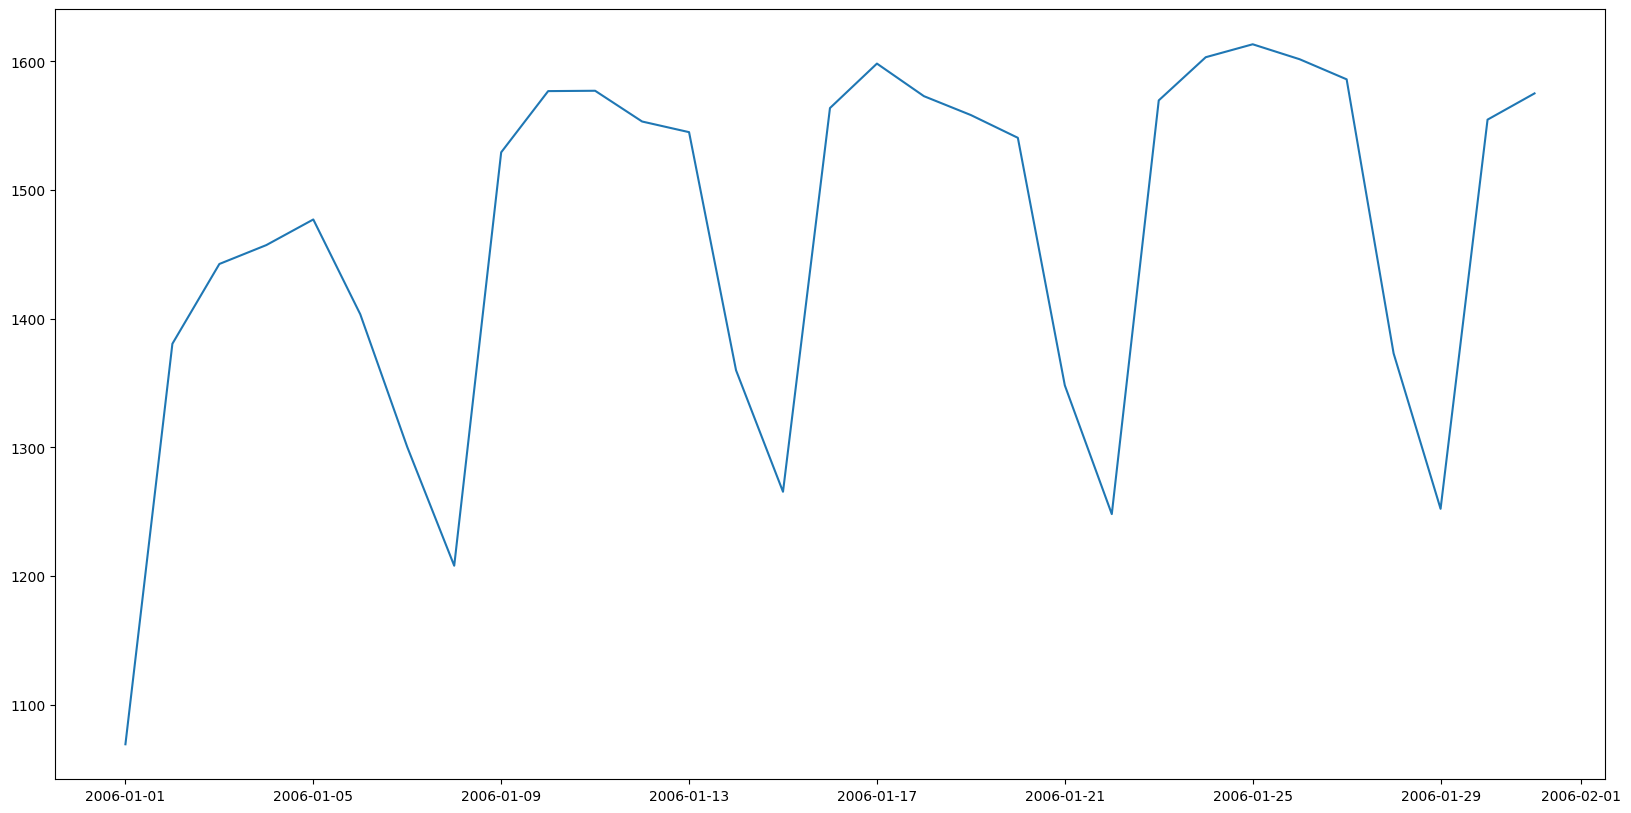

In [16]:
# Plot over a month
plt.figure(figsize=(20,10))
plt.plot(df['Consumption'][:31])
plt.show()

When zooming on a month, we oberve another seasonality. There seems to be days of the week in which people consume less. For example, here's what happens when we highlight Sundays :

In [17]:
def isSunday(dates):
    return [date.weekday()==6 for date in dates]

In [18]:
df['isSunday'] = isSunday(df.index)

In [19]:
df

Consumption     Wind   Solar  Wind+Solar  Prod-Cons  isSunday
Date                                                                     
2006-01-01   1069.18400      NaN     NaN         NaN        NaN      True
2006-01-02   1380.52100      NaN     NaN         NaN        NaN     False
2006-01-03   1442.53300      NaN     NaN         NaN        NaN     False
2006-01-04   1457.21700      NaN     NaN         NaN        NaN     False
2006-01-05   1477.13100      NaN     NaN         NaN        NaN     False
...                 ...      ...     ...         ...        ...       ...
2017-12-27   1263.94091  394.507  16.530     411.037 -852.90391     False
2017-12-28   1299.86398  506.424  14.162     520.586 -779.27798     False
2017-12-29   1295.08753  584.277  29.854     614.131 -680.95653     False
2017-12-30   1215.44897  721.247   7.467     728.714 -486.73497     False
2017-12-31   1107.11488  721.176  19.980     741.156 -365.95888      True

[4383 rows x 6 columns]

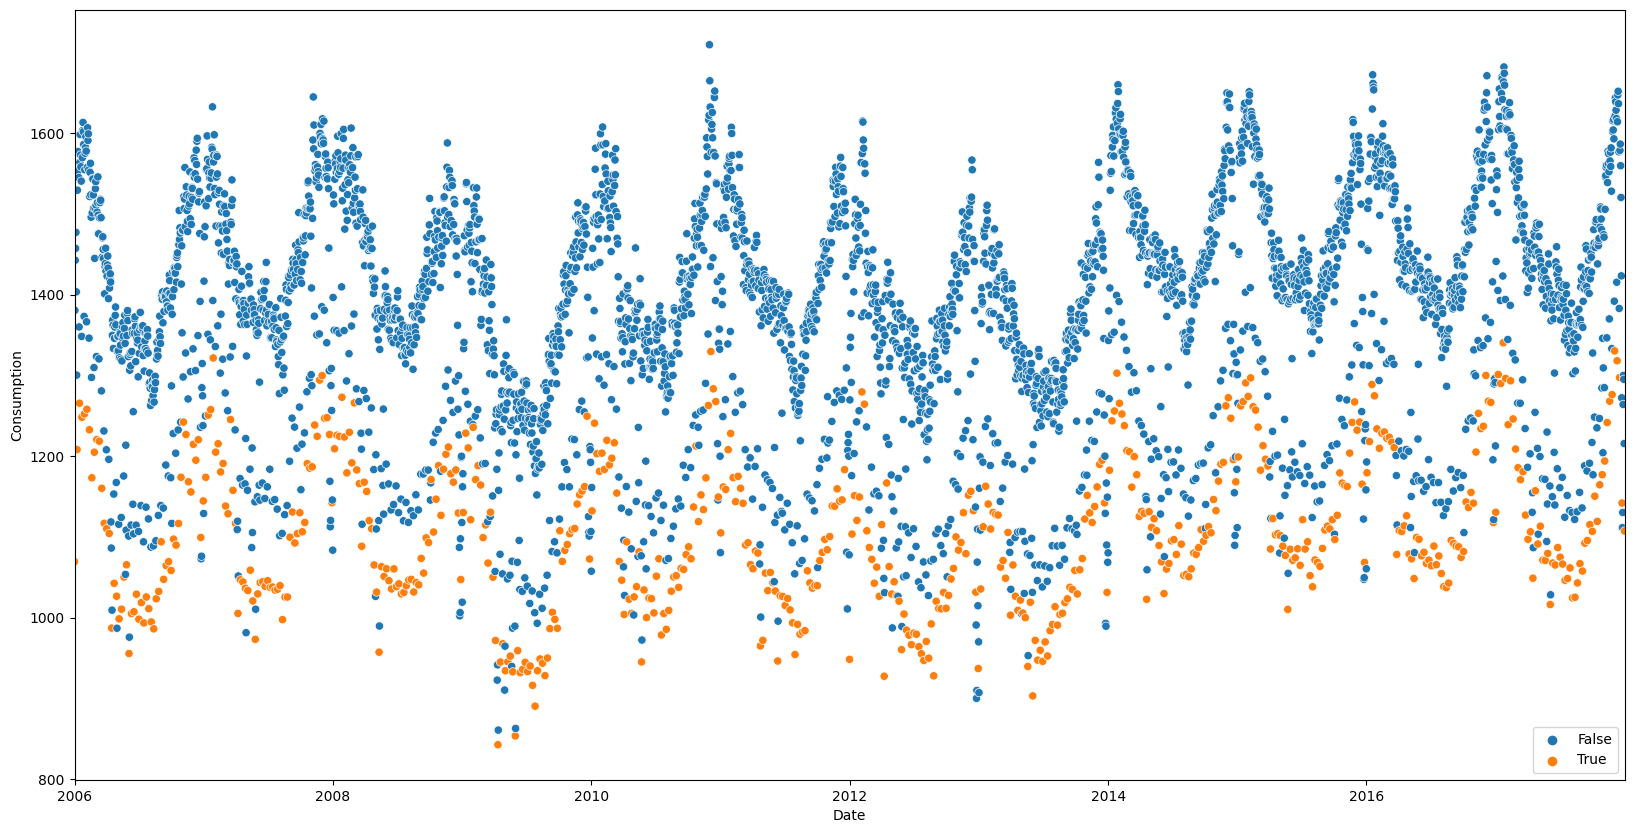

In [20]:
# Plot on Sundays
plt.figure(figsize=(20,10))
sns.scatterplot(x=df.index, y=df.Consumption, hue=df.isSunday)
plt.xlim((df.index[0], df.index[-1]))
plt.legend(loc='lower right')
plt.show()

### 3. Further exploration

Let's creates 'Year' and 'Month' columns

In [21]:
df.index.year

Int64Index([2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='Date', length=4383)

In [22]:
df['Year'] = df.index.year

In [23]:
df['Month'] = df.index.month

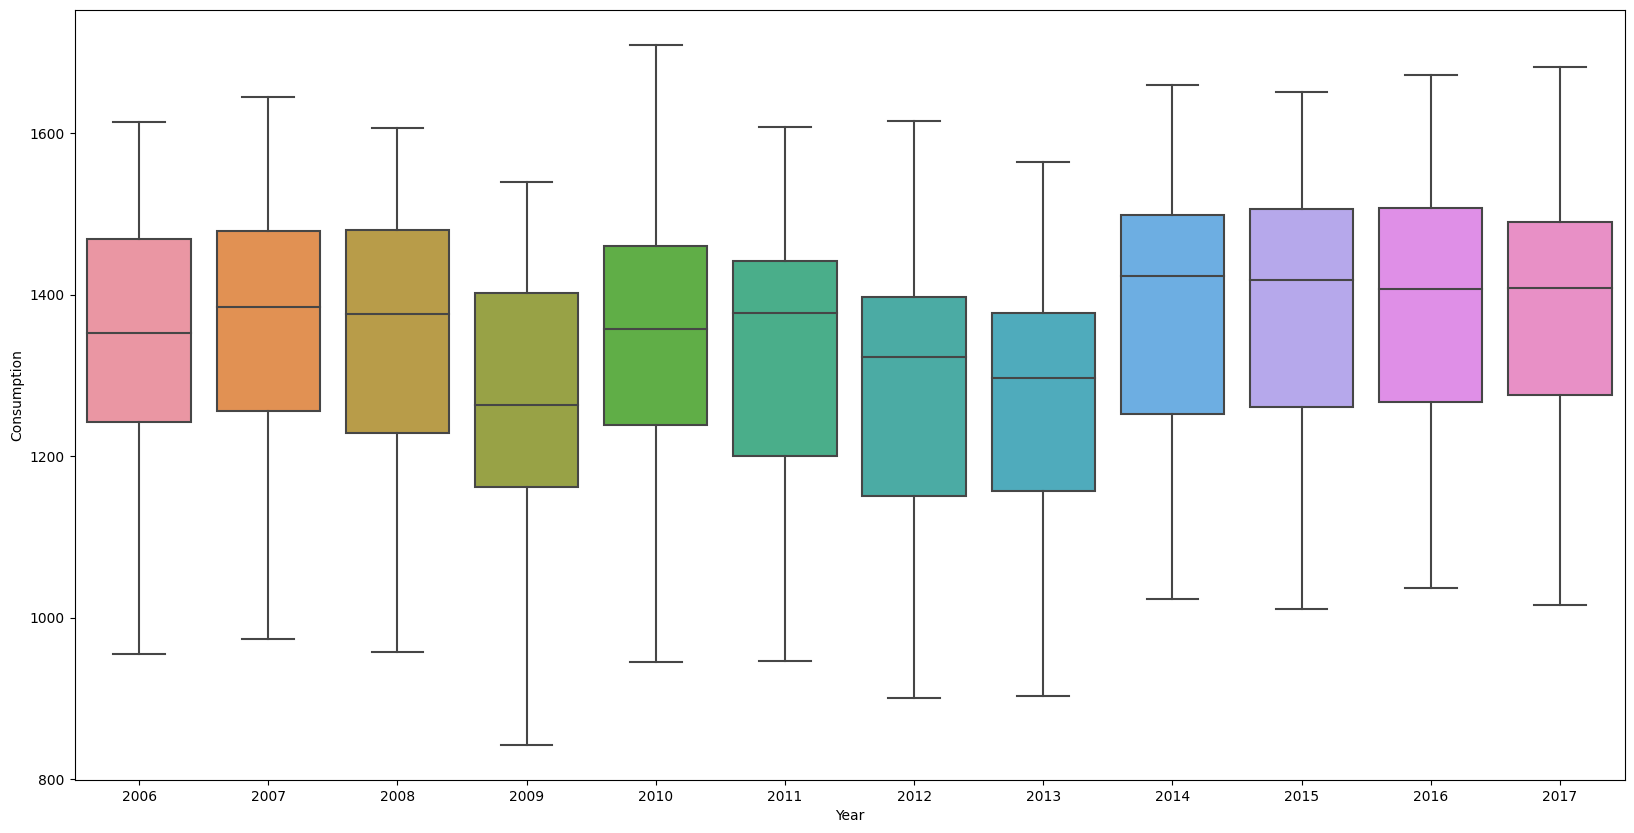

In [24]:
# Boxplot year
plt.figure(figsize=(20,10))
sns.boxplot(x='Year', y='Consumption', data=df)
plt.show()

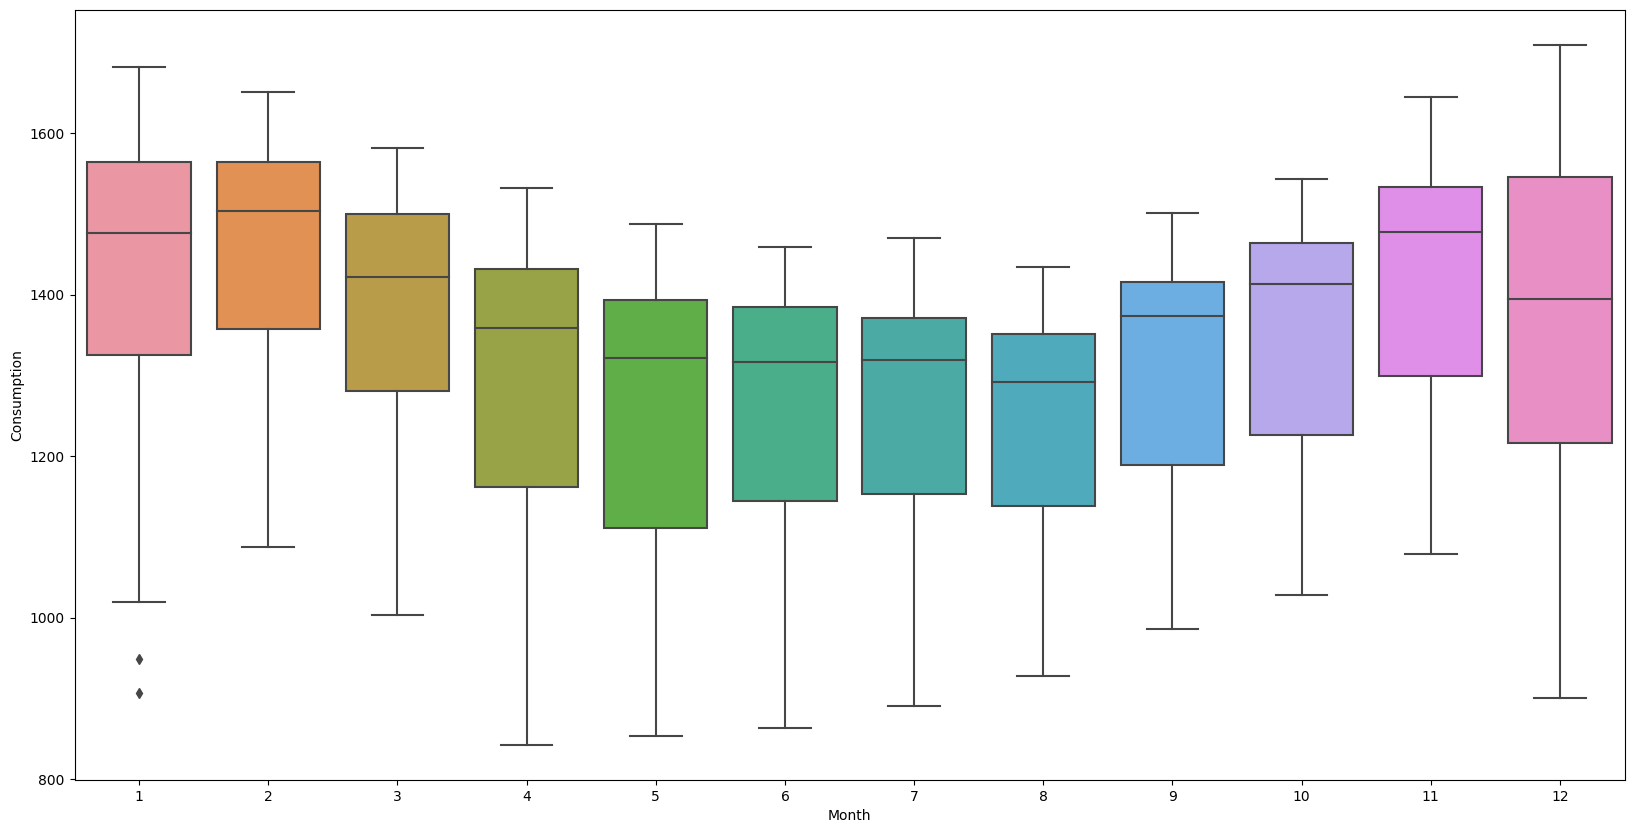

In [25]:
# Boxplot month
plt.figure(figsize=(20,10))
sns.boxplot(x='Month', y='Consumption', data=df)
plt.show()

### 4. Fill missing values

There are missing values on wind production before 2010 and on solar production before 2012.

I've decided to keep data that is available from 2012 for both datasets in a first place, as 'interpolate' method provided by pandas does not work as expected.

In [40]:
solar_ts = df.Solar

In [41]:
solar_ts_reduced = solar_ts.dropna(axis=0)

In [43]:
solar_ts_reduced

Date
2012-01-01     6.587
2012-01-02     6.574
2012-01-03    24.679
2012-01-04    14.681
2012-01-05     5.071
               ...  
2017-12-27    16.530
2017-12-28    14.162
2017-12-29    29.854
2017-12-30     7.467
2017-12-31    19.980
Name: Solar, Length: 2188, dtype: float64

In [47]:
wind_ts = df.Wind

In [49]:
wind_ts_reduced = wind_ts.loc[(wind_ts.index >= '2012-01-01')]

In [50]:
wind_ts_reduced

Date
2012-01-01    227.465
2012-01-02    207.327
2012-01-03    473.468
2012-01-04    499.804
2012-01-05    523.851
               ...   
2017-12-27    394.507
2017-12-28    506.424
2017-12-29    584.277
2017-12-30    721.247
2017-12-31    721.176
Name: Wind, Length: 2192, dtype: float64

## I. Key concepts in time series

For what comes next, we will only focus on the consumption (and the prediction of the consumption). 

Let's plot the autocorrelation and partial autocorrelation of the consumption.

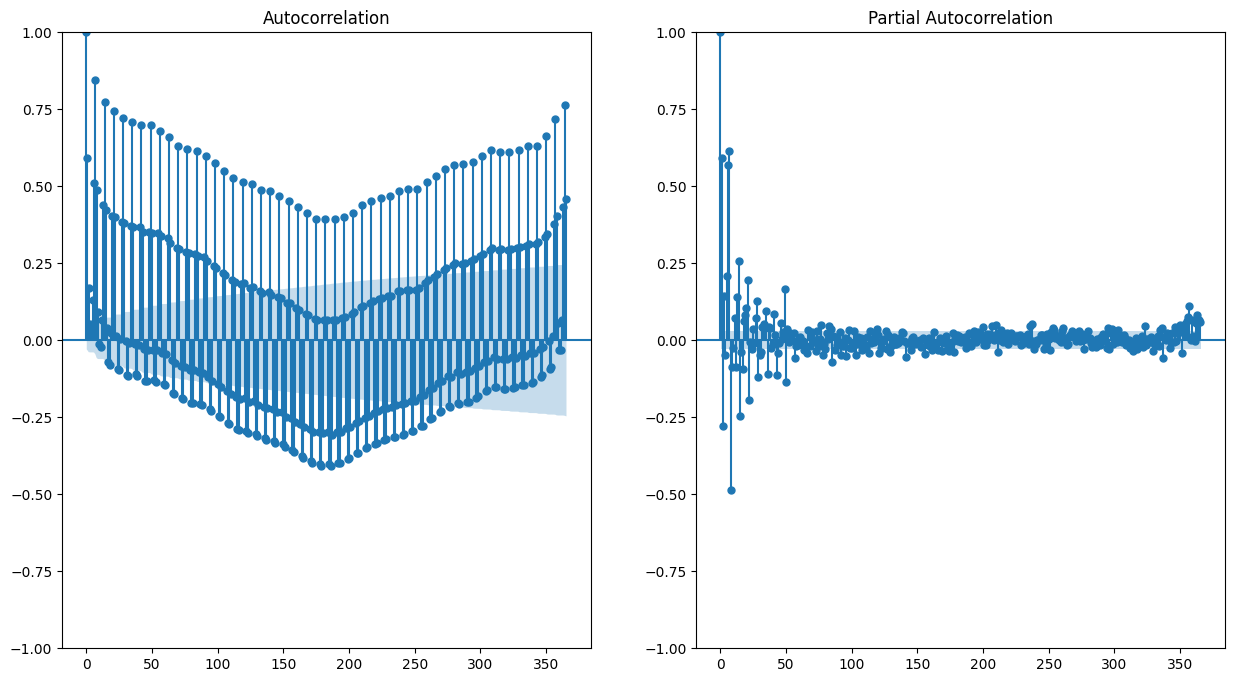

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))

fig = sm.graphics.tsa.plot_acf(df['Consumption'], lags=365, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df['Consumption'], lags=365, ax=axes[1], method='ywm')

We can see high autocorrelation

Q2 - Is the series stationary ? 

In [53]:
# ADFuller 
result = adfuller(df['Consumption'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.239148
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


**Since critical value -6.24 < -3.4,-2.9,-2.6 (t-values at 1%, 5% and 10% confidence intervals), null hypothesis can be rejected. The series is stationary.<br>(Also p-value = 0 < 0.05)<br>We can directly forecast values on this series.**

### 4. Model the stationary series

In [107]:
series = series.loc[(wind_ts.index >= '2017-01-01')]

In [122]:
size = int(len(series)*0.8)
train_series = series[:size]
test_series = series[size:]
test_series = test_series.reset_index()['Consumption']

#### Moving Average (MA) processes

In [123]:
from sklearn.metrics import mean_squared_error

# train, test & history
history = [x for x in train_series]
predictions = []

In [ ]:
# walk forward over time steps in test
for t in range(len(test_series)):
    model = ARIMA(history, order=(1,1,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_series[t]
    history.append(yhat)

C:\Users\ggimo\anaconda3\envs\ds_projects\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ggimo\anaconda3\envs\ds_projects\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ggimo\anaconda3\envs\ds_projects\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ggimo\anaconda3\envs\ds_projects\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ggimo\anaconda3\envs\ds_projects\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ggimo\anaconda3\envs\ds_projects\lib\site-packages\statsmodels\base\model.py

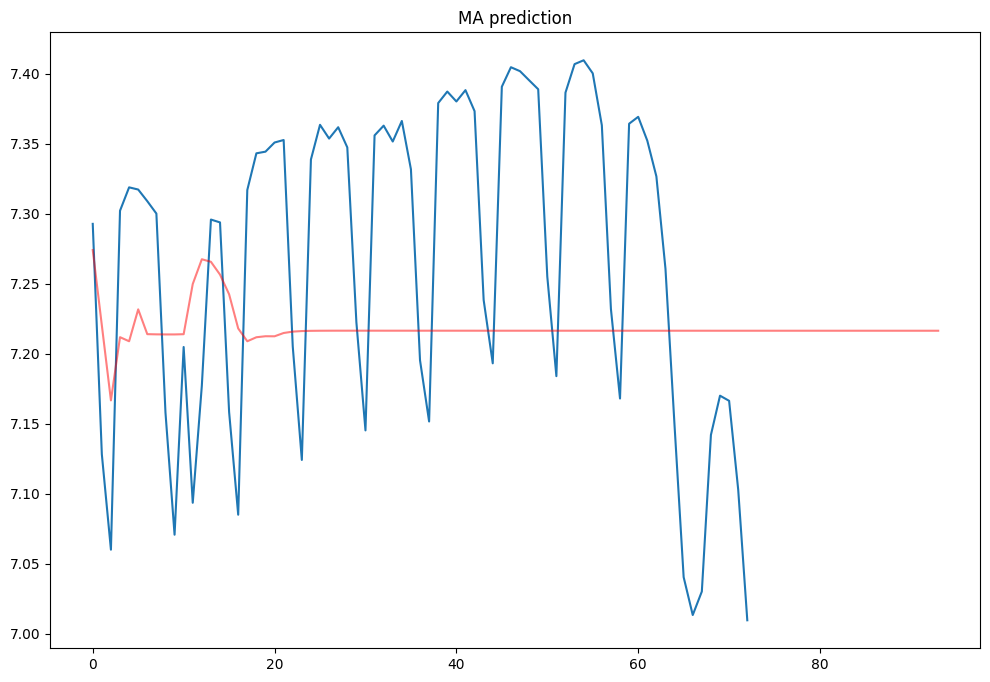

In [132]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test_series)
plt.title("MA prediction")
plt.plot(predictions, color='red',alpha=0.5)
plt.show()

Zoom on the prediction :

In [85]:
# Zoom

In [86]:
# MSE
mean_squared_error(predictions, test_series)

ValueError: Found input variables with inconsistent numbers of samples: [0, 877]

#### Auto Regressive (AR) processes

Q10 - Apply an Auto Regressive process on 20 % of test data. Comment your results.

In [ ]:
history = [x for x in train_series]
predictions = []

In [ ]:
for t in range(len(test_series)):
    model = ARMA(history, order=(2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.predict()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_series[t]
    history.append(yhat)

In [ ]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test_series)
plt.title("AR prediction")
plt.plot(predictions, color='red',alpha=0.5)
plt.show()

In [ ]:
# Zoom

The AR model is not performing well.

In [ ]:
# MSE
mean_squared_error(predictions, test_series)

#### Auto Regressive Moving Average (ARMA) processes

Q11 - Apply an Auto Regressive Moving Average process on 20 % of test data. Comment your results.

In [ ]:
history = [x for x in train_series]
predictions = []

In [ ]:
for t in range(len(test_series)):
    model = ARMA(history, order=(1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.predict()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_series[t]
    history.append(yhat)

In [ ]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test_series)
plt.title("ARMA prediction")
plt.plot(predictions, color='red',alpha=0.5)
plt.show()

Zoom on the prediction :

In [ ]:
# Zoom

In [ ]:
# MSE
mean_squared_error(predictions, test_series)

#### Auto Regressive Integrated Moving Average (ARIMA) processes

Q12 - Apply an Auto Regressive Integrated Moving Average process on 5 % of test data. Comment your results.

In [ ]:
size = int(df.shape[0]*0.95)
train_series = series[:size]
test_series = series[size:]
test_series = test_series.reset_index()['Consumption']

In [ ]:
history = [x for x in train_series]
predictions = []

In [ ]:
for t in range(len(test_series)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.predict()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_series[t]
    history.append(yhat)

In [ ]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test_series)
plt.title("ARIMA prediction")
plt.plot(predictions, color='red',alpha=0.5)
plt.show()

Zoom on the prediction :

In [ ]:
# Zoom

In [ ]:
# MSE
mean_squared_error(predictions, test_series)

#### Seasonal Autoregressive Integrated Moving-Average (SARIMA) process

Q13 - There is a seasonal pattern over time that we cannot remove. SARIMA might help ! Fit and predict with a SARIMA model on 80% of the data.

In [29]:
size = int(df.shape[0]*0.80)
train_series = series[:size]
test_series = series[size:]
test_series = test_series.reset_index()['Consumption']

In [30]:
history = [x for x in train_series]
predictions = []

In [31]:
for t in range(len(test_series)):
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1, 7))
    model_fit = model.fit(disp=0)
    output = model_fit.predict()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_series[t]
    history.append(yhat)

/home/guillaume/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/guillaume/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/guillaume/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/guillaume/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/guillaume/.pyenv/v

KeyboardInterrupt: 

In [ ]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(t est_series)
plt.title("SARIMAX prediction")
plt.plot(predictions, color='red',alpha=0.5)
plt.show()

Zoom on the prediction :

In [ ]:
# Zoom

In [ ]:
# MSE

#### Time series recomposition

Q14 - Now that you identified the best model, build the prediction by recomposing the time series !

In [ ]:
# Plot

### 5. Using Prophet

Q15 - Apply a model with Prophet. Comment your results.

In [22]:
# Plot